# Классификатор эмоций

В этом нойтбуке создается и обучается модель для классификации эмоций по изображению лица

In [1]:
import tensorflow as tf 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input, decode_predictions as resnet50_decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input, decode_predictions as vgg16_decode_predictions 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input, decode_predictions as xception_decode_predictions 


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from pathlib import Path

import random
import datetime as dt 
import os

## Опредление путей к данным

In [2]:
# флаг использования Google drive как хранилища данных
USE_GOOGLE_DRIVE = True

#Корневая папка проекта
root_dir = ''

In [3]:
#Подключаем google drive, если код будет выполняться в Colab
if USE_GOOGLE_DRIVE:
    from google.colab import drive

    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Projects/EmoDetector'
    
    import sys
    sys.path.append(root_dir)

    #скачиваем исходные данные
    import gdown
    url = 'https://drive.google.com/uc?id=1pm86O0t_0caQq3b3Qz5iNI3T77p2o-C1'
    output = 'train.zip'
    gdown.download(url, output, quiet=False)

    #распакуем архив
    !unzip -q train.zip

#if

Mounted at /content/drive


Downloading...
From: https://drive.google.com/uc?id=1pm86O0t_0caQq3b3Qz5iNI3T77p2o-C1
To: /content/train.zip
2.27GB [00:29, 78.4MB/s]


In [4]:
import emo_utils as utils

In [5]:
#Получаем пути к директориям и файлам проекта

paths = utils.get_paths(root_dir)

print (paths)

{'data_dir': '/content/drive/My Drive/Projects/EmoDetector/data', 'model_dir': '/content/drive/My Drive/Projects/EmoDetector/model', 'train_data_dir': '/content/drive/My Drive/Projects/EmoDetector/data/train', 'train_aug_data_dir': '/content/drive/My Drive/Projects/EmoDetector/data/train_aug', 'val_data_dir': '/content/drive/My Drive/Projects/EmoDetector/data/val', 'test_data_dir': '/content/drive/My Drive/Projects/EmoDetector/data/test_kaggle', 'class_names_path': '/content/drive/My Drive/Projects/EmoDetector/data/class_names.txt', 'best_checkpoint_path': '/content/drive/My Drive/Projects/EmoDetector/model/emo_classificator_best'}


In [6]:
'Переопределяем локальные пути к данным для Google Colab'
if USE_GOOGLE_DRIVE:
    paths['train_data_dir'] = '/content/train'
    paths['train_aug_data_dir'] = '/content/train_aug'
    paths['val_data_dir'] = '/content/val'
#if

## Создание модели

In [7]:
# Гиперпараметры
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
NUM_CLASSES = 9
EPOCHS = 20
LEARNING_RATE=0.01

#тип базовой модели
BASE_MODEL = 'resnet50'
IMAGE_SIZE = 224

#Тип используемой аугментации
#0 - не используется
#1 - используется аугментация "на лету", случайным образом измененные картинки генерируются генератором в процессе обучения
#2 - используется заранее сгенерированный расширенный (аугментированный) набор изображений для обучения
AUG_TYPE = 1

#Флаг что модель будет дообучаться
RESUME_TRAINING = False
#Чекпоинт, с которого продолжиться обучение
checkpoint_path = paths['model_dir'] + '/emo_classificator_best_resnet50_e10_acc_34.h5'

In [16]:
def create_model (p_base_model, p_num_classes = 9):
    '''
    Создание модели для классификации эмоций по картинке
    
    :argument
    p_base_model - тип базовой модели:
     resnet50
     vgg16
     xception
         
    p_num_classes - количество определяемых классов
    
    return:
    base_model- базовая модель, предназначенная для извлечения признаков с картинки
    model - модель для классификации эмоций, построенная на базовой модели
    preprocessed_input - функция для обработки входных данных для базовой модели
    decode_predictions - функция для расшифровки предсказания базовой модели
    
    '''
    
    base_model = None
    model = None
    preprocess_input = None
    decode_predictions = None
    
    if p_base_model == 'resnet50':        
        
        base_model = ResNet50(weights='imagenet')
        #отрежем последние слои
        #base_layers = tf.keras.Model([base_model.input], base_model.get_layer("avg_pool").output)
        base_layers = ResNet50(weights="imagenet",
                               input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                               include_top=False)
        
        #добавим новые слои для обучения и классификации

        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        #"заморозим" часть базовых слоев
#        for layer in base_layers.layers:
#            if layer.name.find('conv5_block3') == -1:
#                layer.trainable = False

        
        preprocess_input = resnet50_preprocess_input
        decode_predictions = resnet50_decode_predictions
        
    #if
    if p_base_model == 'vgg16':            
             
        base_model = VGG16(weights='imagenet')
        base_layers = VGG16(weights="imagenet",
                            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                            include_top=False)
        
        #добавим новые слои для обучения и классификации
        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        
        #"заморозим" часть базовых слоев
        for layer in base_layers.layers:
            if layer.name.find('block5') == -1:
                layer.trainable = False
        
        preprocess_input = vgg16_preprocess_input
        decode_predictions = vgg16_decode_predictions
        
    #if
    
    if p_base_model == 'xception':
        
             
        base_model = Xception(weights='imagenet')
                
        base_layers = tf.keras.applications.Xception(weights="imagenet",
                                                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                 include_top=False)
    
        #добавим новые слои для обучения и классификации       
        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])

        
        #"заморозим" часть базовых слоев
 #       for layer in base_layers.layers:
 #           if layer.name.find('block14') == -1:
 #               layer.trainable = False
        
        preprocess_input = xception_preprocess_input
        decode_predictions = xception_decode_predictions
        
    #if
      
    return base_model, model, preprocess_input, decode_predictions

#create_model

In [17]:
base_model, model_emo_classifier, preprocess_input, decode_predictions = create_model (p_base_model=BASE_MODEL)

model_emo_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 18441     
Total params: 23,606,153
Trainable params: 23,553,033
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

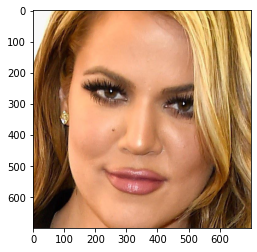

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n03676483', 'lipstick', 0.40090132), ('n03916031', 'perfume', 0.054402564), ('n03476991', 'hair_spray', 0.051147483)]


In [11]:
#Проверим базовую модель

img_path = paths['test_data_dir'] + '/4999.jpg'

#Отобразим картинку
plt.imshow(mpimg.imread(img_path))
plt.show()

x = utils.preprocess_image(img_path, (IMAGE_SIZE, IMAGE_SIZE), preprocess_input)

preds = base_model.predict(x)

#print(preds)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [12]:
# Создадим генератор картинок для обучения модели

if AUG_TYPE < 2:

    if AUG_TYPE == 0:
        image_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                       validation_split = VALIDATION_SPLIT)
    
    elif AUG_TYPE == 1:
        image_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                       validation_split = VALIDATION_SPLIT,
                                       horizontal_flip=True,
                                       zoom_range=0.2,
                                       height_shift_range=0.2,
                                       width_shift_range=0.2,
                                       rotation_range=15)
    
    train_generator = image_gen.flow_from_directory (directory= paths['train_data_dir'],
                                                     class_mode= 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                     subset = 'training')

    val_generator = image_gen.flow_from_directory (directory= paths['train_data_dir'],
                                                   class_mode= 'categorical', 
                                                   batch_size = BATCH_SIZE, 
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   subset = 'validation',
                                                   shuffle = False)

#if

elif AUG_TYPE == 2:
    image_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
    
    train_generator = image_gen.flow_from_directory (directory= paths['train_aug_data_dir'],
                                                     class_mode= 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE))

    val_generator = image_gen.flow_from_directory (directory= paths['val_data_dir'],
                                                   class_mode= 'categorical', 
                                                   batch_size = BATCH_SIZE, 
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                    shuffle = False)
#elif
    

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


In [13]:
# Сохраним список классов, чтобы можно было их в последствии декодировать

classes_names = ''
for key in train_generator.class_indices.keys():
    if classes_names == '': 
        classes_names = key
    else:
        classes_names = classes_names + ',' + key

with open(paths['class_names_path'], 'w') as output:
    output.write(classes_names)

In [19]:
aug = ''
if AUG_TYPE > 0:
    aug = '_aug'+str(AUG_TYPE)

if not RESUME_TRAINING:
    checkpoint_path = paths['best_checkpoint_path'] \
                      +'_'+ dt.datetime.now().strftime ('%y%m%d%H%M%S') \
                      +'_'+ BASE_MODEL \
                      + '_e'+ str(EPOCHS) \
                      + aug +'.h5'

    #скомпилируем модель
    model_emo_classifier.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9),
                                 loss= 'categorical_crossentropy',
                                 metrics= ['accuracy'])

#    model_emo_classifier.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#                                 loss= 'categorical_crossentropy',
#                                 metrics= ['accuracy'])
#if

else:
    # Загрузим модель
    model_emo_classifier = tf.keras.models.load_model(checkpoint_path)
      
    checkpoint_path =  checkpoint_path.replace('.h5', '_e' + str(EPOCHS) + '.h5')
#else    


#Создаем объект для сохранения модели во время обучения
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor= 'val_accuracy',
                                                verbose= 1, 
                                                save_best_only= True, 
                                                mode='max')

In [20]:
# Обучение модели

history = model_emo_classifier.fit(train_generator,
                                   validation_data = val_generator,
                                   epochs = EPOCHS,
                                   callbacks = [checkpoint])

Epoch 1/20
1252/1252 [==============================] - 971s 772ms/step - loss: 1.8904 - accuracy: 0.3264 - val_loss: 1.6200 - val_accuracy: 0.4072

Epoch 00001: val_accuracy improved from -inf to 0.40721, saving model to /content/drive/My Drive/Projects/EmoDetector/model/emo_classificator_best_210120045559_resnet50_e20_aug1.h5
Epoch 2/20
1252/1252 [==============================] - 922s 737ms/step - loss: 1.4484 - accuracy: 0.4772 - val_loss: 1.4875 - val_accuracy: 0.4667

Epoch 00002: val_accuracy improved from 0.40721 to 0.46667, saving model to /content/drive/My Drive/Projects/EmoDetector/model/emo_classificator_best_210120045559_resnet50_e20_aug1.h5
Epoch 3/20
1252/1252 [==============================] - 920s 735ms/step - loss: 1.3632 - accuracy: 0.5046 - val_loss: 1.3984 - val_accuracy: 0.4936

Epoch 00003: val_accuracy improved from 0.46667 to 0.49355, saving model to /content/drive/My Drive/Projects/EmoDetector/model/emo_classificator_best_210120045559_resnet50_e20_aug1.h5
Epoc

In [21]:
history.history

{'accuracy': [0.39416569471359253,
  0.4803067147731781,
  0.5012113451957703,
  0.5188691020011902,
  0.5296086072921753,
  0.5375009179115295,
  0.549414336681366,
  0.5567571520805359,
  0.5670720934867859,
  0.5742151141166687,
  0.5858038663864136,
  0.5900247097015381,
  0.5969679355621338,
  0.6066335439682007,
  0.6120033264160156,
  0.6197956800460815,
  0.6286870241165161,
  0.6390768885612488,
  0.6460700631141663,
  0.6508154273033142],
 'loss': [1.6720579862594604,
  1.4324427843093872,
  1.3663642406463623,
  1.3184900283813477,
  1.2850801944732666,
  1.2594759464263916,
  1.2302366495132446,
  1.20722234249115,
  1.1832647323608398,
  1.159914255142212,
  1.1403672695159912,
  1.1202075481414795,
  1.0997200012207031,
  1.0759599208831787,
  1.0592741966247559,
  1.0388554334640503,
  1.0148930549621582,
  0.9922233819961548,
  0.9666804075241089,
  0.9527726173400879],
 'val_accuracy': [0.4072149395942688,
  0.4666733145713806,
  0.4935545027256012,
  0.467172980308532

In [22]:
#Добавляем информацию о точности в название чекпоинта

acc = str(int(round(max(history.history['val_accuracy']), 2)*100))

new_checkpoint_path = checkpoint_path.replace ('.h5', '_acc' + acc + '.h5')

os.rename (checkpoint_path, new_checkpoint_path)
checkpoint_path = new_checkpoint_path

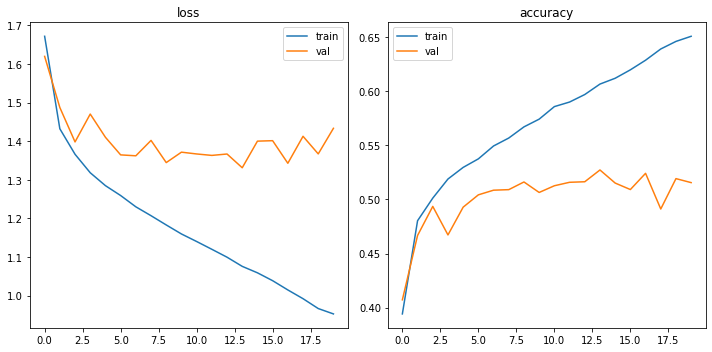

In [23]:
#Визуализируем данные обучения

fig = plt.figure(tight_layout=True)

#задаем размерность сетки для размещения графиков
gs= fig.add_gridspec(1,2)
fig.set_size_inches(10, 5)

ax = fig.add_subplot(gs[0,0])
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'val')
        
#Добавление подписей на график
ax.set_title('loss')
ax.legend()

ax = fig.add_subplot(gs[0,1])
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'val')

ax.set_title('accuracy')
ax.legend()

plt.savefig(checkpoint_path.replace('.h5', '.png'))
plt.show()

## Тест модели

In [24]:
# Загрузим модель
model = tf.keras.models.load_model(checkpoint_path)

#model.evaluate(val_generator)

In [25]:
#загрузим названия классов
classes_names = []
with open(paths['class_names_path'], 'r') as f:
    classes_names = f.read().split(',')

In [26]:
# выберем картинки для проверки
sample_cnt = 12

sample_img_paths = []
sample_img_labels = []
for i in range (sample_cnt):
    index = random.choice(range(0, len(val_generator.filepaths)))
    sample_img_paths.append (val_generator.filepaths[index])
    sample_img_labels.append (val_generator.labels[index])
    
#for

print (sample_img_paths)
print (sample_img_labels)

['/content/train/fear/1796.jpg', '/content/train/contempt/129.jpg', '/content/train/surprise/1623.jpg', '/content/train/anger/1314.jpg', '/content/train/fear/1160.jpg', '/content/train/anger/1519.jpg', '/content/train/fear/1119.jpg', '/content/train/fear/1206.jpg', '/content/train/happy/1118.jpg', '/content/train/uncertain/1597.jpg', '/content/train/fear/1075.jpg', '/content/train/contempt/1502.jpg']
[3, 1, 7, 0, 3, 0, 3, 3, 4, 8, 3, 1]


In [27]:
#import importlib
#importlib.reload (utils)

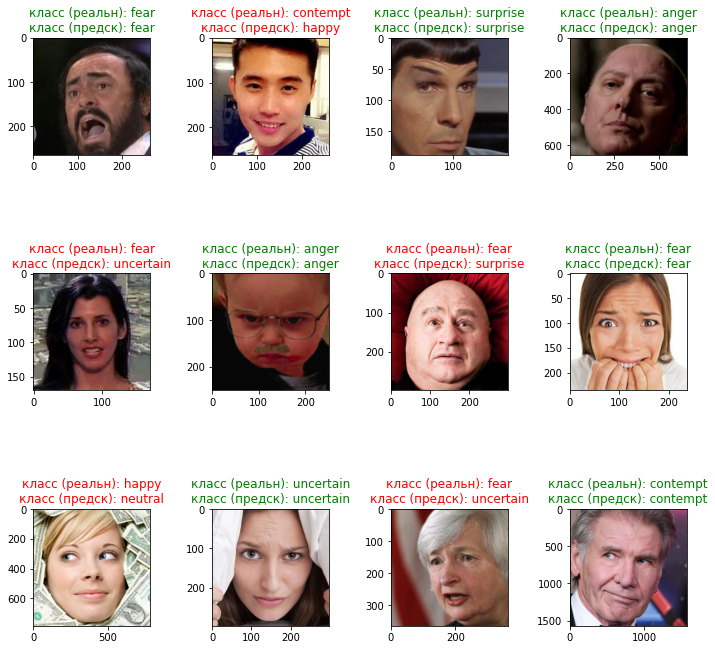

In [28]:
# Тест предсказания

utils.test_model_prediction (p_model = model,
                             p_img_paths = sample_img_paths,
                             p_img_emo_idxs = sample_img_labels,
                             p_img_target_size = (IMAGE_SIZE, IMAGE_SIZE),
                             preprocess_func = preprocess_input,
                             p_emo_classes_names = classes_names)